## Select X and y

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import pickle 

#load file from pickle
with open('scrapping_and_data_pickles/dataframe_1008.pkl', 'rb') as picklefile: 
    dataframe = pickle.load(picklefile)

#transform to dataframe
df = pd.DataFrame(dataframe)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


#specify columns to use for modeling

X = df.drop(['title','address','floor_level', \
                'post_date','construction_type',\
                'public_transit','rate_term','rate_price'],axis=1)

y = df['rate_price']


## Observe Dependent Variable (Y) distribution

In [3]:
test = df[['sqft', 'nearby_public_transit', 'days_of_listing','rate_price']]

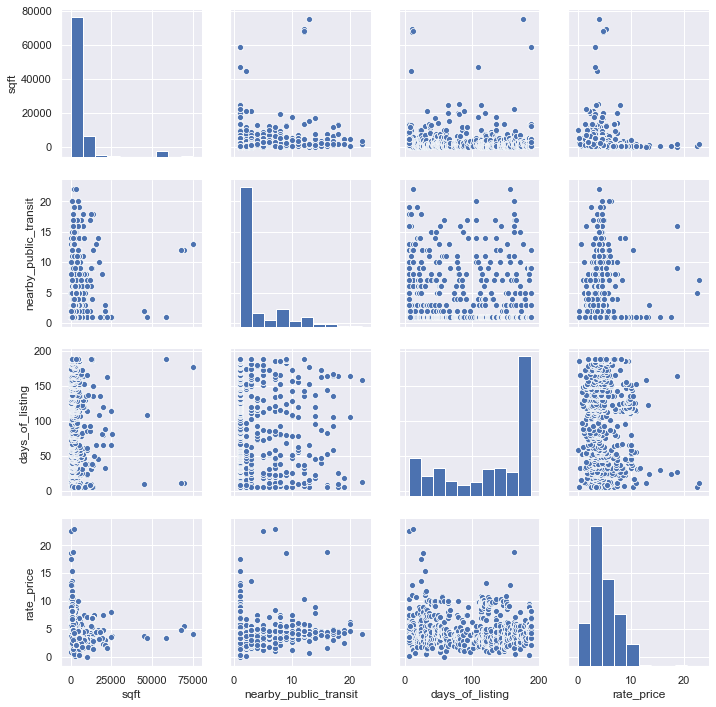

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

sns.pairplot(test)
plt.show()

## Standard Regression

In [11]:
def split_and_validate_scaled(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=12345)
    
    X_train, X_val, y_train, y_val = \
        train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 10)
    
    numeric = ['sqft','nearby_public_transit','days_of_listing','sqft_reverse', 'transit_reverse', 'daysListing_poly']
    #'sqft_reverse', 'transit_reverse', 'daysListing_poly'

    X_train_1 = X_train[numeric]
    X_train_2 = X_train.drop(columns = numeric)
    
    X_val_1 = X_val[numeric]
    X_val_2 = X_val.drop(columns = numeric)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_1.values)
    X_val_scaled = scaler.transform(X_val_1.values)
    
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train_1.join(X_train_2), y_train)
    
    # score fit model on validation data
    train_score = lr_model.score(X_train_1.join(X_train_2), y_train)
    val_score = lr_model.score(X_val_1.join(X_val_2), y_val)
    
    # report results
    print('\nTraining R^2 score was:', train_score)
    print('\nValidation R^2 score was:', val_score)
    
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
#     return X_val_1.join(X_val_2), y_val, lr_model

**Basic linear regression model doesn't work in this case!**

## Reverse Regression

In [6]:
X_reverse = X.copy()

X_reverse['sqft_reverse'] = 1/X_reverse['sqft']
X_reverse['transit_reverse'] = 1/X_reverse['nearby_public_transit']


# split_and_validate_scaled(X_reverse, y)

Validation R^2 improved to 0.53 after adding two 1/X variables!

## Polynomial Regression

In [7]:
X_poly = X_reverse.copy()

X_poly['daysListing_poly'] =  X_reverse['days_of_listing'] ** 2


# split_and_validate_scaled(X_poly, y)

Validation R^2 increased by 0.004 by increasing a polynomial variable

## Interaction Features

In [12]:
X_interactive = X_poly.copy()

X_interactive['sqft_x_listingDays'] =  X_poly['sqft'] * X_poly['days_of_listing']
X_interactive['sqft_x_transit'] = X_poly['sqft'] * X_poly['nearby_public_transit']


split_and_validate_scaled(X_interactive, y)


Training R^2 score was: 0.625593809107024

Validation R^2 score was: 0.5364367339901481
Feature coefficient results: 

sqft : -0.00
construct_year : 0.03
has_renovated : -0.01
common_kitchen : 466.62
showers : 0.85
key_card_access : 0.00
on_site_security : 0.00
furniture : 0.50
turnkey : 0.49
natural_light : -0.81
high_ceilings : 0.16
plug_and_play : -0.61
nearby_public_transit : 0.70
Brick : -0.31
Concrete : -0.41
Glass : -0.40
Masonry : -0.47
None : 0.05
Steel : 0.32
Stone : 0.88
Tiltwall : -0.01
Wood : 0.32
days_of_listing : -0.07
building_class_A : 0.62
building_class_B : 0.00
building_class_C : -0.12
building_class_D : -0.02
building_class_None : -0.50
month_April : -1.12
month_August : 1.67
month_July : -0.03
month_June : -1.82
month_May : 0.93
month_October : 0.33
month_September : 0.46
district_10 West 33rd Street : -1.21
district_11 Broadway : 1.07
district_1441 Broadway : 0.25
district_152 West 57th Street : 1.14
district_156 West 56th Street : 0.33
district_30-30 47th Avenu

## Cross Validation

In [13]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X_poly, y, cv=10, scoring='r2')

array([-3.38512871e-01,  3.09424837e-01,  2.67447450e-02,  5.63997623e-01,
        2.87450531e-01, -1.18179892e+15,  2.44943737e-01,  9.87422520e-01,
        9.88054512e-01,  9.87444438e-01])

In [14]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X_poly, y, cv=kf, scoring='r2')))
# print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.5334605317504929


## LassoCV

In [15]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [16]:
#LASSO CV
def lasso_scaled(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=10)
    
    X_train, X_val, y_train, y_val = \
        train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 10)
    
    numeric = ['sqft','nearby_public_transit','days_of_listing', 'sqft_reverse','transit_reverse','daysListing_poly']

    X_train_1 = X_train[numeric]
    X_train_2 = X_train.drop(columns = numeric)
    
    X_val_1 = X_val[numeric]
    X_val_2 = X_val.drop(columns = numeric)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_1.values)
    X_val_scaled = scaler.transform(X_val_1.values)
    
    
    
    
    alphavec = 10**np.linspace(1,2,300)

    ridge_model = RidgeCV(alphas = alphavec, cv=10)
    ridge_model.fit(X_train_1.join(X_train_2), y_train)
    
    
    
    
#      # score fit model on validation data
    train_score = ridge_model.score(X_train_1.join(X_train_2), y_train)
    val_score = ridge_model.score(X_val_1.join(X_val_2), y_val)
    
#     report results
    print('\nTraining R^2 score was:', train_score)
    print('\nValidation R^2 score was:', val_score)
    
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, ridge_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
#     print (lasso_model.alpha_)

In [17]:
np.set_printoptions(precision=10)

In [18]:
lasso_scaled(X_poly, y)


Training R^2 score was: 0.5245493729425507

Validation R^2 score was: 0.31490575063305304
Feature coefficient results: 

sqft : -0.00
construct_year : 0.10
has_renovated : -0.02
common_kitchen : 0.06
showers : 1.28
key_card_access : 0.00
on_site_security : -0.00
furniture : -0.05
turnkey : 0.42
natural_light : 0.17
high_ceilings : 0.24
plug_and_play : -0.99
nearby_public_transit : 0.98
Brick : -0.05
Concrete : -0.52
Glass : -0.39
Masonry : -0.36
None : -0.12
Steel : 0.08
Stone : 0.42
Tiltwall : -0.35
Wood : 0.28
days_of_listing : 0.18
building_class_A : 0.34
building_class_B : 0.00
building_class_C : -0.19
building_class_D : 0.21
building_class_None : -0.01
month_April : -0.58
month_August : 0.25
month_July : 0.14
month_June : -0.69
month_May : 0.29
month_October : -0.05
month_September : 0.75
district_10 West 33rd Street : -0.47
district_11 Broadway : 0.05
district_1441 Broadway : 0.13
district_152 West 57th Street : 0.00
district_156 West 56th Street : -0.14
district_30-30 47th Aven

Opps, regularization makes validation score worse, which means data is still underrepresented by the model. Need more data to feed in.

## Test on Testing Data

In [19]:
X_rest, X_test, y_rest, y_test = \
    train_test_split(X_interactive, y, test_size=0.2, random_state=10)

numeric = ['sqft','nearby_public_transit','days_of_listing','sqft_reverse', 'transit_reverse', 'daysListing_poly']

# only scale on numeric variables
X_rest_1 = X_rest[numeric]
X_rest_2 = X_rest.drop(columns = numeric)

X_test_1 = X_test[numeric]
X_test_2 = X_test.drop(columns = numeric)

scaler = StandardScaler()
X_rest_scaled = scaler.fit_transform(X_rest_1.values)
X_test_scaled = scaler.transform(X_test_1.values)    
    

# fit linear regression to training data
new_X_rest = X_rest_1.join(X_rest_2)
new_X_test = X_test_1.join(X_test_2)
lr_model = LinearRegression()
lr_model.fit(new_X_rest, y_rest)

# score fit model on validation data
# train_score = lr_model.score(X_train_1.join(X_train_2), y_train)
test_score = lr_model.score(new_X_test, y_test)

# report results
# print('\nTraining R^2 score was:', train_score)
print('\nTesting R^2 score is:', test_score)



Testing R^2 score is: 0.5330938976678545


## Plot Prediction Residual

In [22]:
# define graph residual functions
def graph_pred_vs_actual(actual,pred,data_type):
    plt.scatter(actual,pred,alpha=.3)
    plt.plot(np.linspace(int(min(pred)),int(max(pred)),int(max(pred))),np.linspace(int(min(pred)),int(max(pred)),int(max(pred))))
    plt.title('Actual vs Pred ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Pred')  
#     plt.savefig('images/pred_actual_test.png')
    plt.show()
    
def graph_residual(actual,residual,data_type):
    plt.scatter(actual,residual,alpha=.3)
    plt.plot(np.linspace(int(min(actual)),int(max(actual)),int(max(actual))),np.linspace(0,0,int(max(actual))))
    plt.title('Actual vs Residual ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Residual')
#     plt.savefig('images/actual_residual_test.png')
    plt.show()

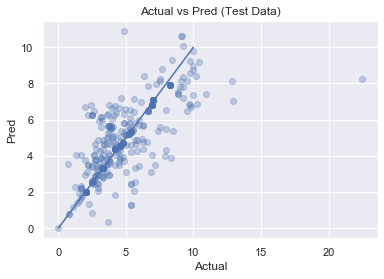

In [23]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,lr_model.predict(new_X_test),'Test')

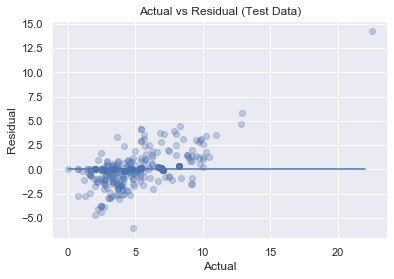

In [24]:
## Residual Plot
graph_residual(y_test,y_test-lr_model.predict(new_X_test),'Test')

In [25]:
# MAD
(np.mean(np.abs(lr_model.predict(new_X_test) - y_test)))

0.9990070100559308